In [1]:
import xarray as xr

# Path to your NetCDF file
dataset_path = '/Users/samagra/INCOIS/GHRSST/combined_ghrsst_data.nc'
ds = xr.open_dataset(dataset_path, chunks={'time': 1, 'latitude': 100, 'longitude': 100})

# Check the dataset structure
print(ds)

<xarray.Dataset> Size: 13GB
Dimensions:       (time: 8111, latitude: 501, longitude: 801)
Coordinates:
  * time          (time) datetime64[ns] 65kB 2002-09-01T12:00:00 ... 2024-04-...
  * latitude      (latitude) float32 2kB 0.025 0.075 0.125 ... 24.92 24.98 25.02
  * longitude     (longitude) float32 3kB 60.03 60.08 60.12 ... 99.97 100.0
Data variables:
    analysed_sst  (time, latitude, longitude) float32 13GB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes: (12/50)
    acknowledgement:            NOAA/NESDIS
    cdm_data_type:              Grid
    comment:                    The Geo-Polar Blended Sea Surface Temperature...
    Conventions:                CF-1.6, Unidata Observation Dataset v1.0, COA...
    creator_email:              john.sapper@noaa.gov
    creator_name:               Office of Satellite Products and Operations
    ...                         ...
    summary:                    Analyzed blended sea surface temperature over...
    testOutOfDate:    

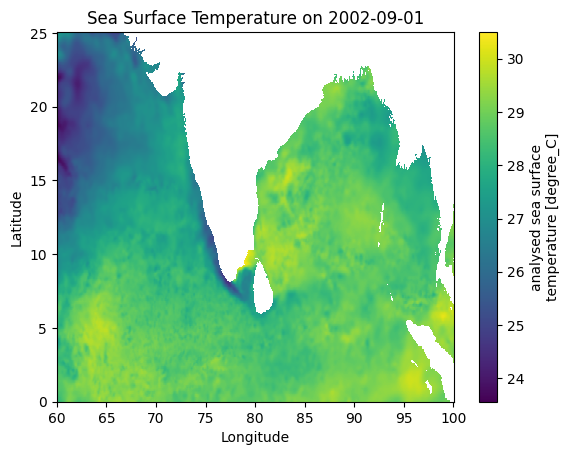

In [3]:
import matplotlib.pyplot as plt

# Plotting the first time slice of the SST data
ds['analysed_sst'].isel(time=0).plot(cmap='viridis')
plt.title('Sea Surface Temperature on 2002-09-01')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

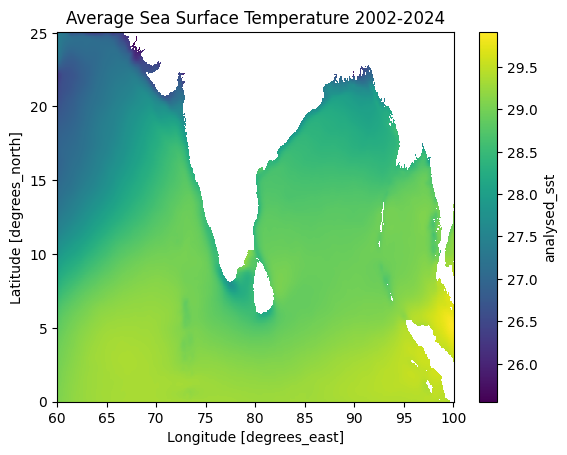

In [5]:
# Basic statistics for the first time step
# print(ds['analysed_sst'].isel(time=0).describe())

# Temporal average to see the overall spatial pattern over time
mean_sst = ds['analysed_sst'].mean(dim='time')
mean_sst.plot()
plt.title('Average Sea Surface Temperature 2002-2024')
plt.show()

<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


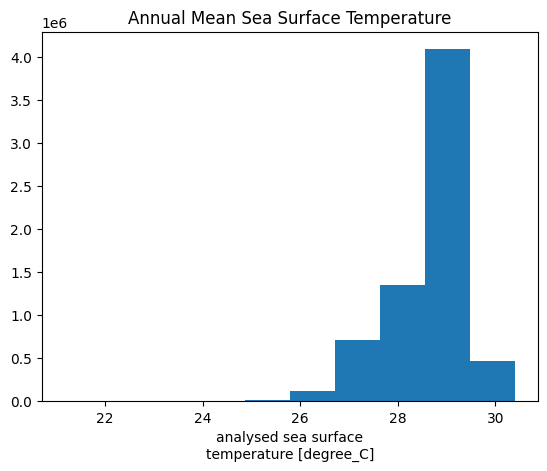

In [6]:
# Resample data to annual means to see longer-term trends
annual_sst = ds['analysed_sst'].resample(time='1Y').mean()
annual_sst.plot()
plt.title('Annual Mean Sea Surface Temperature')
plt.show()

In [7]:
import numpy as np
import xarray as xr

# Assuming ds is your loaded dataset
sst_data = ds['analysed_sst']

# Create a masked array where NaNs are ignored
masked_sst = sst_data.where(~np.isnan(sst_data), other=np.nan)

In [16]:
# Train/Test Split
train = ds.sel(time=slice(None, '2022-01-01'))
test = ds.sel(time=slice('2022-01-01', None))

In [17]:
# Example: Save preprocessed data
train.to_netcdf('train_dataset.nc')
test.to_netcdf('test_dataset.nc')

In [18]:
# Reload the dataset to verify
reloaded_train = xr.open_dataset('train_dataset.nc')

# Print to check it matches expectations
print(reloaded_train)

<xarray.Dataset> Size: 12GB
Dimensions:       (time: 7252, latitude: 501, longitude: 801)
Coordinates:
  * time          (time) datetime64[ns] 58kB 2002-09-01T12:00:00 ... 2022-01-...
  * latitude      (latitude) float32 2kB 0.025 0.075 0.125 ... 24.92 24.98 25.02
  * longitude     (longitude) float32 3kB 60.03 60.08 60.12 ... 99.97 100.0
Data variables:
    analysed_sst  (time, latitude, longitude) float32 12GB ...
Attributes: (12/50)
    acknowledgement:            NOAA/NESDIS
    cdm_data_type:              Grid
    comment:                    The Geo-Polar Blended Sea Surface Temperature...
    Conventions:                CF-1.6, Unidata Observation Dataset v1.0, COA...
    creator_email:              john.sapper@noaa.gov
    creator_name:               Office of Satellite Products and Operations
    ...                         ...
    summary:                    Analyzed blended sea surface temperature over...
    testOutOfDate:              now-2days
    time_coverage_end:       

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, Flatten

2024-04-29 18:19:01.341066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import xarray as xr

# Replace 'your_data.nc' with the actual path to your NetCDF files
ds = xr.open_dataset('/Users/samagra/INCOIS/train_dataset.nc')

# Extract SST data; this assumes the variable is named 'analysed_sst'
sst_data = ds['analysed_sst'].values  # This will give you a 3D NumPy array of shape [time, lat, lon]

In [6]:
mask = ~np.isnan(sst_data)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Flatten the data to 2D for scaling (time, lat*lon)
# We apply the mask and only reshape the non-NaN parts of the data
sst_data_reshaped = sst_data[mask].reshape(-1, 1)

# Scale the non-NaN data
sst_data_scaled = scaler.fit_transform(sst_data_reshaped)

# Initialize a full-sized NaN array to place the scaled values back into their original positions
sst_data_full = np.full(sst_data.shape, np.nan)

# Put the scaled values back into their original positions
sst_data_full[mask] = sst_data_scaled.flatten()

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Grab sequence_length frames
        y.append(data[i])  # Grab the frame immediately following the last frame in X
    return np.array(X), np.array(y)

# Define the sequence length (how many time steps/frames the model will see)
sequence_length = 52  # For instance, 52 weeks for a year's data

# Generate the sequences
X, y = create_sequences(sst_data_scaled, sequence_length)

# Note: X will be of shape [samples, sequence_length, lat, lon]
# y will be of shape [samples, lat, lon]

In [ ]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
import torch

# Convert the training and testing sets to tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float().unsqueeze(1)  # Add an extra dimension for target
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float().unsqueeze(1)

In [6]:
# Convert numpy arrays to tensors
train_data = torch.tensor(X_train).float().unsqueeze(-1).to(device)  # Add channel dimension
train_labels = torch.tensor(y_train).float().to(device)
test_data = torch.tensor(X_test).float().unsqueeze(-1).to(device)
test_labels = torch.tensor(y_test).float().to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1000):  # Number of epochs
    model.train()
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 692.2794799804688
Epoch 2, Loss: 688.8920288085938
Epoch 3, Loss: 685.5477294921875
Epoch 4, Loss: 682.2454223632812
Epoch 5, Loss: 678.983154296875
Epoch 6, Loss: 675.758544921875
Epoch 7, Loss: 672.568115234375
Epoch 8, Loss: 669.4083251953125
Epoch 9, Loss: 666.2750854492188
Epoch 10, Loss: 663.1644287109375
Epoch 11, Loss: 660.0717163085938
Epoch 12, Loss: 656.9925537109375
Epoch 13, Loss: 653.92236328125
Epoch 14, Loss: 650.8564453125
Epoch 15, Loss: 647.790283203125
Epoch 16, Loss: 644.7193603515625
Epoch 17, Loss: 641.6390991210938
Epoch 18, Loss: 638.5452880859375
Epoch 19, Loss: 635.4337158203125
Epoch 20, Loss: 632.3005981445312
Epoch 21, Loss: 629.1419677734375
Epoch 22, Loss: 625.9546508789062
Epoch 23, Loss: 622.7353515625
Epoch 24, Loss: 619.4812622070312
Epoch 25, Loss: 616.1898193359375
Epoch 26, Loss: 612.8588256835938
Epoch 27, Loss: 609.4862670898438
Epoch 28, Loss: 606.0704345703125
Epoch 29, Loss: 602.60986328125
Epoch 30, Loss: 599.103271484375
Epoc

Epoch 239, Loss: 167.5751495361328
Epoch 240, Loss: 166.56419372558594
Epoch 241, Loss: 165.55833435058594
Epoch 242, Loss: 164.55751037597656
Epoch 243, Loss: 163.5617218017578
Epoch 244, Loss: 162.5709686279297
Epoch 245, Loss: 161.5851593017578
Epoch 246, Loss: 160.60438537597656
Epoch 247, Loss: 159.62852478027344
Epoch 248, Loss: 158.6576385498047
Epoch 249, Loss: 157.69161987304688
Epoch 250, Loss: 156.7305145263672
Epoch 251, Loss: 155.77430725097656
Epoch 252, Loss: 154.8229522705078
Epoch 253, Loss: 153.87640380859375
Epoch 254, Loss: 152.93463134765625
Epoch 255, Loss: 151.9977264404297
Epoch 256, Loss: 151.06556701660156
Epoch 257, Loss: 150.1381378173828
Epoch 258, Loss: 149.2154541015625
Epoch 259, Loss: 148.2974853515625
Epoch 260, Loss: 147.3842315673828
Epoch 261, Loss: 146.47564697265625
Epoch 262, Loss: 145.5717315673828
Epoch 263, Loss: 144.67245483398438
Epoch 264, Loss: 143.77777099609375
Epoch 265, Loss: 142.88771057128906
Epoch 266, Loss: 142.002197265625
Epoch 2

Epoch 472, Loss: 33.86773681640625
Epoch 473, Loss: 33.60680389404297
Epoch 474, Loss: 33.347618103027344
Epoch 475, Loss: 33.09019470214844
Epoch 476, Loss: 32.83451461791992
Epoch 477, Loss: 32.5805549621582
Epoch 478, Loss: 32.32830810546875
Epoch 479, Loss: 32.07780075073242
Epoch 480, Loss: 31.828964233398438
Epoch 481, Loss: 31.581851959228516
Epoch 482, Loss: 31.336408615112305
Epoch 483, Loss: 31.092649459838867
Epoch 484, Loss: 30.85055160522461
Epoch 485, Loss: 30.610116958618164
Epoch 486, Loss: 30.371315002441406
Epoch 487, Loss: 30.134187698364258
Epoch 488, Loss: 29.898653030395508
Epoch 489, Loss: 29.664770126342773
Epoch 490, Loss: 29.432462692260742
Epoch 491, Loss: 29.201791763305664
Epoch 492, Loss: 28.97270393371582
Epoch 493, Loss: 28.745208740234375
Epoch 494, Loss: 28.519277572631836
Epoch 495, Loss: 28.294921875
Epoch 496, Loss: 28.07211685180664
Epoch 497, Loss: 27.850866317749023
Epoch 498, Loss: 27.631166458129883
Epoch 499, Loss: 27.41299057006836
Epoch 500,

Epoch 704, Loss: 4.805144309997559
Epoch 705, Loss: 4.763466835021973
Epoch 706, Loss: 4.722164630889893
Epoch 707, Loss: 4.681241512298584
Epoch 708, Loss: 4.640687942504883
Epoch 709, Loss: 4.600499629974365
Epoch 710, Loss: 4.560683727264404
Epoch 711, Loss: 4.52122688293457
Epoch 712, Loss: 4.482135772705078
Epoch 713, Loss: 4.443398475646973
Epoch 714, Loss: 4.405020713806152
Epoch 715, Loss: 4.366983890533447
Epoch 716, Loss: 4.32930850982666
Epoch 717, Loss: 4.291968822479248
Epoch 718, Loss: 4.254978179931641
Epoch 719, Loss: 4.218332767486572
Epoch 720, Loss: 4.182013988494873
Epoch 721, Loss: 4.146035194396973
Epoch 722, Loss: 4.110393047332764
Epoch 723, Loss: 4.075078964233398
Epoch 724, Loss: 4.040088176727295
Epoch 725, Loss: 4.00542688369751
Epoch 726, Loss: 3.9710845947265625
Epoch 727, Loss: 3.9370594024658203
Epoch 728, Loss: 3.9033546447753906
Epoch 729, Loss: 3.8699612617492676
Epoch 730, Loss: 3.8368852138519287
Epoch 731, Loss: 3.8041141033172607
Epoch 732, Loss: 

Epoch 934, Loss: 0.9696424007415771
Epoch 935, Loss: 0.9658063650131226
Epoch 936, Loss: 0.9620165824890137
Epoch 937, Loss: 0.9582698941230774
Epoch 938, Loss: 0.9545668959617615
Epoch 939, Loss: 0.9509067535400391
Epoch 940, Loss: 0.9472907781600952
Epoch 941, Loss: 0.9437143802642822
Epoch 942, Loss: 0.9401814937591553
Epoch 943, Loss: 0.9366894960403442
Epoch 944, Loss: 0.9332380294799805
Epoch 945, Loss: 0.9298267960548401
Epoch 946, Loss: 0.9264569282531738
Epoch 947, Loss: 0.9231244325637817
Epoch 948, Loss: 0.9198325276374817
Epoch 949, Loss: 0.9165790677070618
Epoch 950, Loss: 0.9133638739585876
Epoch 951, Loss: 0.9101856350898743
Epoch 952, Loss: 0.9070467352867126
Epoch 953, Loss: 0.9039425253868103
Epoch 954, Loss: 0.900876522064209
Epoch 955, Loss: 0.8978463411331177
Epoch 956, Loss: 0.8948521018028259
Epoch 957, Loss: 0.8918935656547546
Epoch 958, Loss: 0.8889700174331665
Epoch 959, Loss: 0.8860816359519958
Epoch 960, Loss: 0.8832256197929382
Epoch 961, Loss: 0.8804049491

In [7]:
model.eval()
with torch.no_grad():
    predicted = model(test_data)
    test_loss = criterion(predicted, test_labels)
print(f'Test MSE: {test_loss.item()}')

Test MSE: 0.9803160429000854


In [8]:
rmse = np.sqrt(702.646)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 26.50747064508419


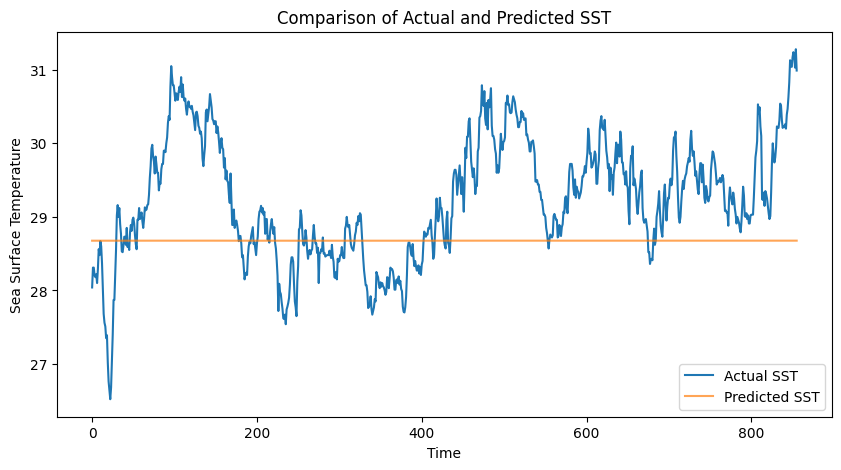

In [12]:
# Ensure your model is in evaluation mode
model.eval()

# Obtain predictions
with torch.no_grad():
    predictions = model(test_data)

# Ensure you convert predictions to CPU and numpy for plotting, if you're using a GPU
predictions = predictions.cpu().numpy()

# Now plot the actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(test_labels.cpu().numpy(), label='Actual SST')
plt.plot(predictions, label='Predicted SST', alpha=0.7)
plt.title('Comparison of Actual and Predicted SST')
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature')
plt.legend()
plt.show()